# AMLS Pipeline for Marge vs Home

In [19]:
import azureml.core
from azureml.core import Workspace, Datastore, Experiment
from azureml.core.model import Model
from azureml.core.compute import ComputeTarget, AmlCompute, DataFactoryCompute
from azureml.pipeline.core import Pipeline, PipelineData
from azureml.core.runconfig import CondaDependencies, RunConfiguration
from azureml.data.data_reference import DataReference
from azureml.pipeline.core.graph import PipelineParameter
from azureml.pipeline.steps import DataTransferStep, PythonScriptStep, EstimatorStep
from azureml.data.datapath import DataPath, DataPathComputeBinding
from azureml.widgets import RunDetails
from azureml.train.dnn import TensorFlow

## Connect to Workspace

In [20]:
ws = Workspace.from_config()

## Connect to Compute

In [21]:
clusterName = "NV6AICluster"
computeCluster = ComputeTarget(workspace=ws, name=clusterName)


# Get some details from your cluster
status = computeCluster.get_status()
print("Current node count: ",status.current_node_count)
print("VM Size: ",status.vm_size)
print("Name:",computeCluster.name)

Current node count:  1
VM Size:  STANDARD_NV6
Name: NV6AICluster


## Connect to storage

In [22]:
## Data store
source_ds = Datastore.get(ws, 'SimpsonDataStore')

## Training data store
training_ds = Datastore.get(ws, 'SimpsonTrainingDataStore')


# Creating the Pipeline

In [23]:
# Parameters make it easy for us to re-run this training pipeline, including for retraining.
source_dataset = DataPath(datastore=source_ds, path_on_datastore="trainingdata")
source_dataset_param = (PipelineParameter(name="source_dataset",default_value=source_dataset),
                          DataPathComputeBinding())

# Location for the step scripts
script_folder = "./steps"

# Name of the model
model_name = "MargeOrHomer-JupyterNB"

# Experiment name
experiment_name = "Marge-or-Homer-JupyterNB"

## Step 1 - Data preparation

In [24]:
# Step environment
cd = CondaDependencies.create(pip_packages=["azureml-sdk","opencv-python"])
amlcompute_run_config = RunConfiguration(conda_dependencies=cd)

# Output location for the pre-proccessed trainings images
training_data_location = PipelineData(name="trainingdata", datastore=training_ds)

# Create the pre-process step
preProcessDataStep = PythonScriptStep(name="Pre-process data",
                            script_name="prep.py",
                            compute_target=computeCluster,
                            runconfig=amlcompute_run_config,
                            inputs=[source_dataset_param],
                            arguments=['--source_path', source_dataset_param,
                                       '--destination_path', training_data_location,
                                        "--pic_size",64
                                      ],
                            outputs=[training_data_location],
                            source_directory=script_folder)

## Step 2 - Train the model

In [25]:
# Output location for the produced model
model = PipelineData(name="model", datastore=training_ds, output_path_on_compute="model")

# Estimator script params
estimator_script_params = [
    "--data-folder", training_data_location,
    "--output-folder", model,
    "--pic-size",64,
    "--batch-size",32,
    "--epochs",10
]

# Create the tensorflow Estimator
trainEstimator = TensorFlow(
                     source_directory = script_folder,
                     compute_target = computeCluster,
                     entry_script = "train.py", 
                     use_gpu = True,
                     use_docker = True,
                     conda_packages=["keras==2.2.2","opencv==3.4.2","scikit-learn"],
                     framework_version="1.10"
                )

# Create a pipeline step with the TensorFlow Estimator
trainOnGpuStep = EstimatorStep(
    name='Train Estimator Step',
    estimator=trainEstimator,
    inputs=[training_data_location],
    outputs=[model],
    compute_target=computeCluster,
    estimator_entry_script_arguments = estimator_script_params
) 

## Step 3 - Register the model

In [26]:
model_id = PipelineData(name="modelId", datastore=training_ds)
registerStep = PythonScriptStep(name="Register model for deployment",
                            script_name="register.py",
                            compute_target=computeCluster,
                            inputs=[model],
                            arguments=['--dataset_name', model_name,
                                       '--model_assets_path', model
                                      ],
                            outputs=[model_id],
                            source_directory=script_folder)

## Create the pipeline

In [27]:
prep_train_register = [preProcessDataStep,trainOnGpuStep,registerStep]

pipeline = Pipeline(workspace=ws, steps=[prep_train_register])
pipeline.validate()

WARNING - 'gpu_support' is no longer necessary; AzureML now automatically detects and uses nvidia docker extension when it is available. It will be removed in a future release.
WARNING - 'gpu_support' is no longer necessary; AzureML now automatically detects and uses nvidia docker extension when it is available. It will be removed in a future release.
WARNING - 'gpu_support' is no longer necessary; AzureML now automatically detects and uses nvidia docker extension when it is available. It will be removed in a future release.


Step Pre-process data is ready to be created [935fea70]
Data reference simpsondatastore_e812f39d is ready to be created [508f251d], (Consumers of this data will generate new runs.)


[]

## Publish the pipeline

In [28]:
mlpipeline = pipeline.publish(name="Marge Or Homer - Training pipeline",)

print("Pipeline Published ID:"+mlpipeline.id)

Created step Pre-process data [935fea70][ca7a02e4-4b3f-49d2-a284-dd0db3453237], (This step will run and generate new outputs)
Created step Train Estimator Step [9e366e01][c1fd31dc-2123-424d-b3f6-329ae6aaf53f], (This step is eligible to reuse a previous run's output)
Created step Register model for deployment [786afd2c][afa7be80-f82d-43f6-a469-605b6448860b], (This step is eligible to reuse a previous run's output)
Created data reference simpsondatastore_e812f39d for StepId [508f251d][97930911-5624-49f7-8f79-c36287284cba], (Consumers of this data will generate new runs.)
Pipeline Published ID:d09ea10e-cfa1-4abd-b69b-75c37e7eb781


## Run the pipeline

In [29]:
pipeline_run = mlpipeline.submit(ws,experiment_name ,pipeline_parameters={"source_dataset":DataPath(datastore=source_ds, path_on_datastore="trainingdata")})


Submitted PipelineRun ce6b99b8-925c-438a-b322-44a81d0c689d
Link to Azure Portal: https://mlworkspace.azure.ai/portal/subscriptions/431dbae5-40ca-438a-8daf-77d7d5580b41/resourceGroups/AMLS-Demo-RG/providers/Microsoft.MachineLearningServices/workspaces/AMLS-Workspace/experiments/Marge-or-Homer-JupyterNB/runs/ce6b99b8-925c-438a-b322-44a81d0c689d


In [30]:
RunDetails(pipeline_run).show()

_PipelineWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', …

## Download the model from the store

In [31]:
import os

model = Model(ws, 'mn.TestFromHenk')

print("Name",model.name)
print("Version",model.version)

output_path = "output"
os.makedirs(output_path, exist_ok=True)

result = model.download(target_dir=output_path, exist_ok=True)

#print(result)

Name mn.TestFromHenk
Version 8


# Testing the model localy

## Load the model

In [32]:
import os
import shutil
import numpy as np
import cv2
import random
import keras
from keras.models import model_from_json

### Settings
json_file_path = "output/model/simple_model.json"
model_file_path = "output/model/simple_model.h5"
test_images_directory = "testset-marge-vs-homer"
pic_size = 64

### characters
map_characters = {0:"marge_simpson", 1: "homer_simpson" }

### Load the model
json_file = open(json_file_path, "r") 
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(model_file_path)  

### Prediction method => image preprocessing + prediction
def predict_image(img):
    image = cv2.imread(img)
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pic = cv2.resize(image, (pic_size,pic_size))
    data = pic.reshape(1, pic_size, pic_size,3)
    predicted_labels = loaded_model.predict(data)[0]
    return predicted_labels, img

print("Loaded")

Using TensorFlow backend.


Loaded


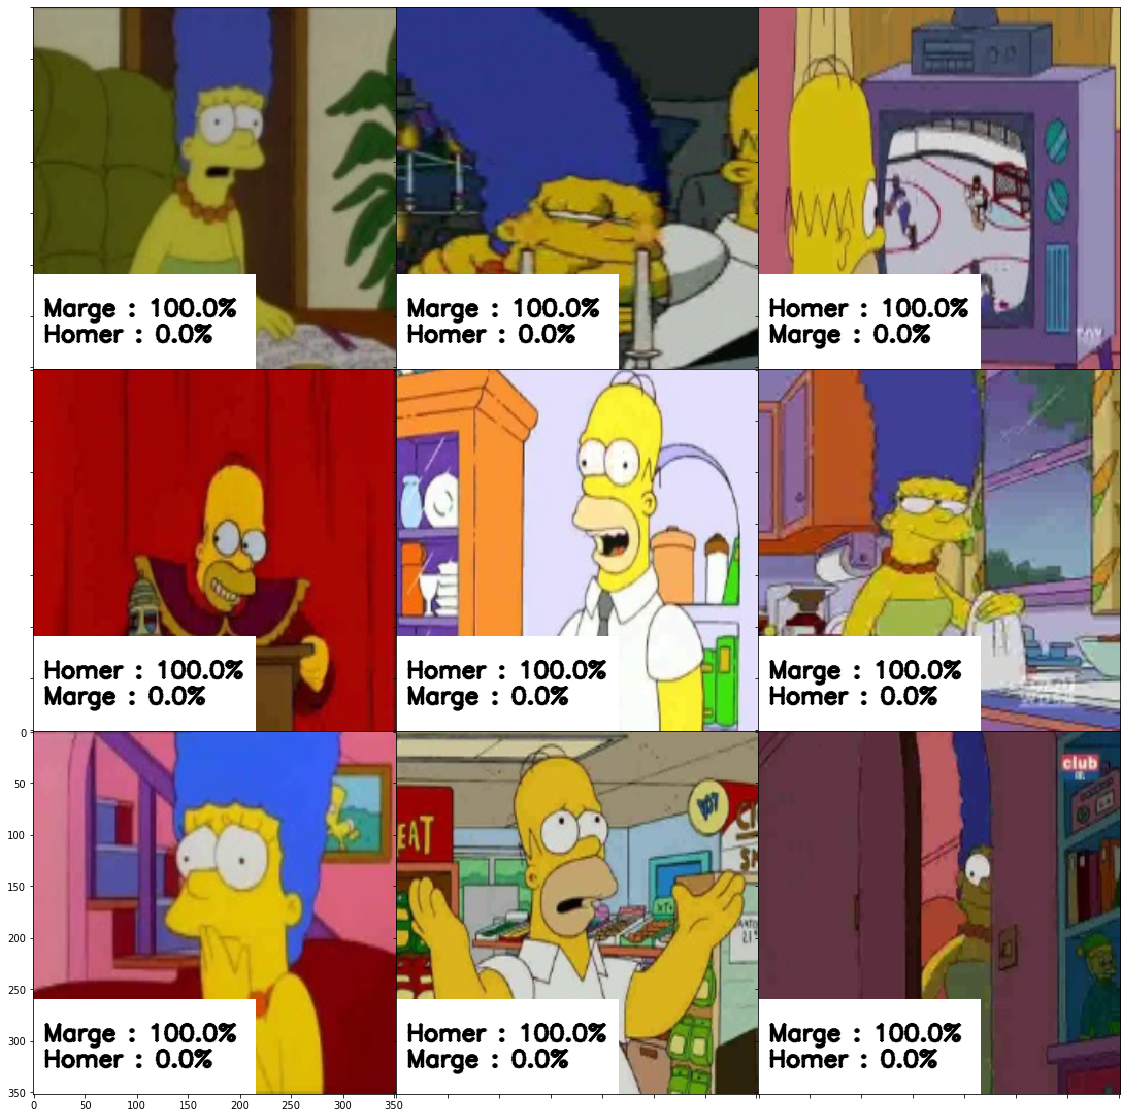

In [34]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

F = plt.figure(1, (20,20))
grid = AxesGrid(F, 111, nrows_ncols=(3, 3), axes_pad=0, label_mode="1")

testimages = os.listdir(test_images_directory)
random.shuffle(testimages)

i = 0
for img_name in testimages[0:9]:
    a, img = predict_image(os.path.join(test_images_directory,img_name))

    text = sorted(["{:s} : {:.1f}%".format(map_characters[k].split("_")[0].title(), 100*v) for k,v in enumerate(a)], 
       key=lambda x:float(x.split(":")[1].split("%")[0]), reverse=True)[:3]
    img = cv2.resize(img, (352, 352))
    cv2.rectangle(img, (0,260),(215,352),(255,255,255), -1)
    font = cv2.FONT_HERSHEY_SIMPLEX

    for k, t in enumerate(text):
        cv2.putText(img, t,(10, 300+k*25), font, 0.75,(0,0,0),2,cv2.LINE_AA)
    grid[i].imshow(img)
    i = i +1